In [2]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Time agnostic

In [3]:
def logistic_regression_I(network: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

time_agnostic_performance = {
  network: logistic_regression_I(network) for network in network_indices}

# Time aware

In [4]:
def logistic_regression_I_II_III_hypergraph(network: int):
  X = dict()
  # Type I features
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
    
  # Type II features
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 'm0', 'm1', 'm2', 'm3']:
        X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'))
  # Type III features      
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 'm0', 'm1']:
          X[(heuristic, time_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

def logistic_regression_I_II_III_simplegraph(network: int):
  X = dict()
  # Type I
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
  # Type II 
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
        X[(time_strategy, nodepair_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}.npy'))
  # Type III
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      X[(heuristic, time_strategy)] = (
        np.load(
          f'data/{network:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy'))
      
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

time_aware_performance = {
  network: logistic_regression_I_II_III_hypergraph(network) 
  for network in hypergraph_indices} | {
  network: logistic_regression_I_II_III_simplegraph(network) 
  for network in simplegraph_indices
}

In [5]:
df = pd.concat(
  {
    'auc (time aware)': pd.Series(time_aware_performance), 
    'auc (time agnostic)': pd.Series(time_agnostic_performance)
  },
  axis=1)
df['category'] = get_networks()['category']

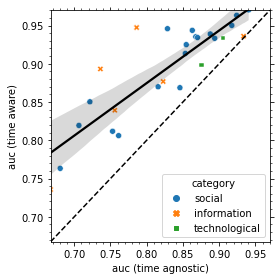

In [6]:
auc_values = df[['auc (time aware)', 'auc (time agnostic)']].values.flatten()
lim = (min(auc_values), max(auc_values))

with plt.rc_context(rc):
  sns.scatterplot(data=df, x='auc (time agnostic)', y='auc (time aware)', hue='category', style='category')
  sns.regplot(data=df, x='auc (time agnostic)', y='auc (time aware)', scatter=False, color='black')
  plt.axline((0,0), (1,1), ls='--', c='black')
  plt.xlim(lim)
  plt.ylim(lim)
  ax = plt.gca()
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  plt.tight_layout()
  plt.savefig('figures/figure-rq1.pdf')

In [7]:
df['difference'] = df['auc (time aware)'] - df['auc (time agnostic)']

<AxesSubplot:xlabel='auc (time agnostic)', ylabel='difference'>

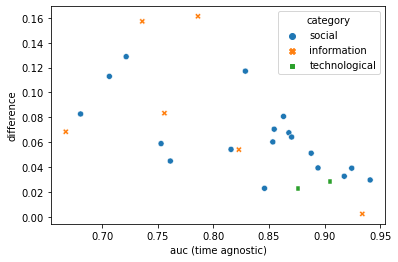

In [8]:
sns.scatterplot(data=df, x='auc (time agnostic)', y='difference', hue='category', style='category')

In [39]:
df['auc (time agnostic)'].mean()

0.8257592494186118

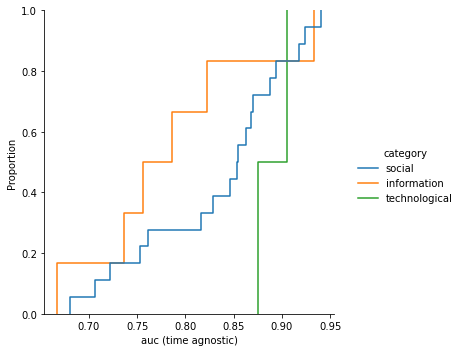

In [38]:
sns.displot(data=df, x='auc (time agnostic)', hue='category', kind='ecdf')

In [41]:
df[df['category'] ==  'technological']

,auc (time aware),auc (time agnostic),category,difference,label
28,0.898535,0.875754,technological,0.022781,Rbody
29,0.933243,0.904957,technological,0.028286,Rtit
